In [1]:
import cv2
from IPython import get_ipython
import matplotlib.pyplot as plt
import numpy as np
import os.path
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

        3537 [__init__.py:            <module>():47] [31116] Creating converter from 7 to 5
        3537 [__init__.py:            <module>():47] [31116] Creating converter from 5 to 7
        3538 [__init__.py:            <module>():47] [31116] Creating converter from 7 to 5
        3538 [__init__.py:            <module>():47] [31116] Creating converter from 5 to 7


In [2]:
fnames = 'Sue_2x_3000_40_-46.tif'
fnames = [download_demo(fnames)]     # the file will be downloaded if it doesn't already exist
m_orig = cm.load_movie_chain(fnames)
downsample_ratio = .2  # motion can be perceived better when downsampling in time
m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

       10095 [utils.py:       download_demo():116] [31116] File Sue_2x_3000_40_-46.tif already downloaded
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
       10393 [movies.py:              resize():1063] [31116] reshaping along z


In [3]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

In [4]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

In [5]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

In [8]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

      110270 [motion_correction.py:motion_correct_rigid():288] [31116] Entering Rigid Motion Correction
      110271 [motion_correction.py:motion_correct_rigid():289] [31116] 296.0
      110320 [movies.py:      extract_shifts():340] [31116] min_val in extract_shifts: -296.0
      110321 [movies.py:      extract_shifts():341] [31116] Movie average is negative. Removing 1st percentile.
      110324 [movies.py:      extract_shifts():359] [31116] Movie average is negative. Removing 1st percentile.
      110357 [movies.py:        apply_shifts():437] [31116] cubic interpolation
      110403 [movies.py:      extract_shifts():340] [31116] min_val in extract_shifts: -296.0
      110404 [movies.py:      extract_shifts():341] [31116] Movie average is negative. Removing 1st percentile.
      110407 [movies.py:      extract_shifts():359] [31116] Movie average is negative. Removing 1st percentile.
      110440 [movies.py:        apply_shifts():437] [31116] cubic interpolation
      110487 [movies.py

  0%|          | 0/1 [00:00<?, ?it/s]      122042 [movies.py:                load():1636] [31116] loading mmap file in memory
      122290 [movies.py:                load():1639] [31116] mmap
100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


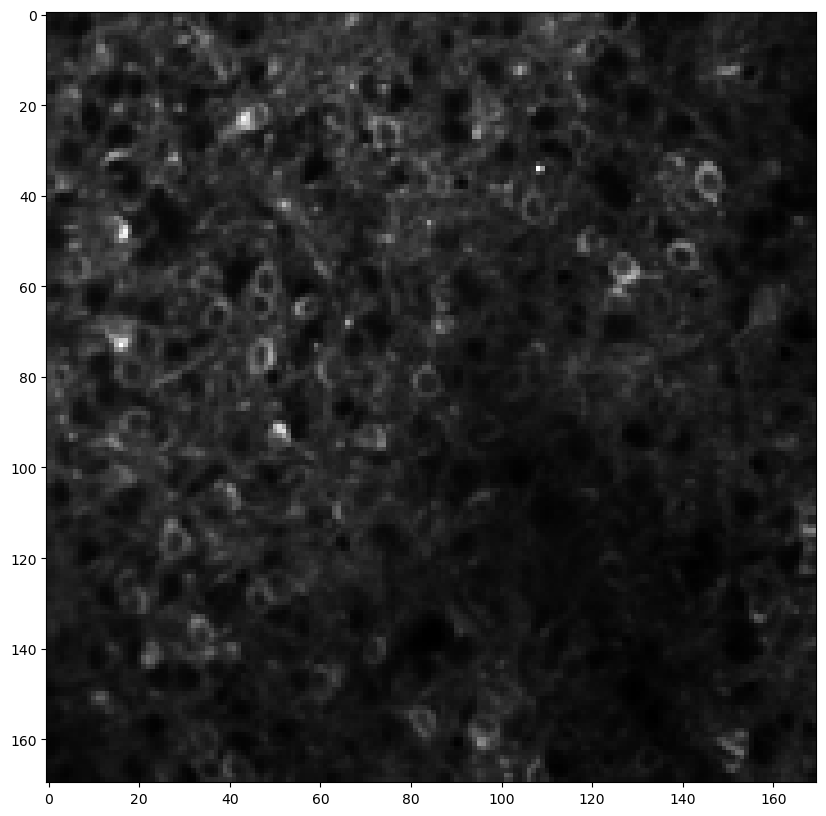

In [9]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)
#%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray');

In [ ]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

      122818 [movies.py:              resize():1063] [31116] reshaping along z


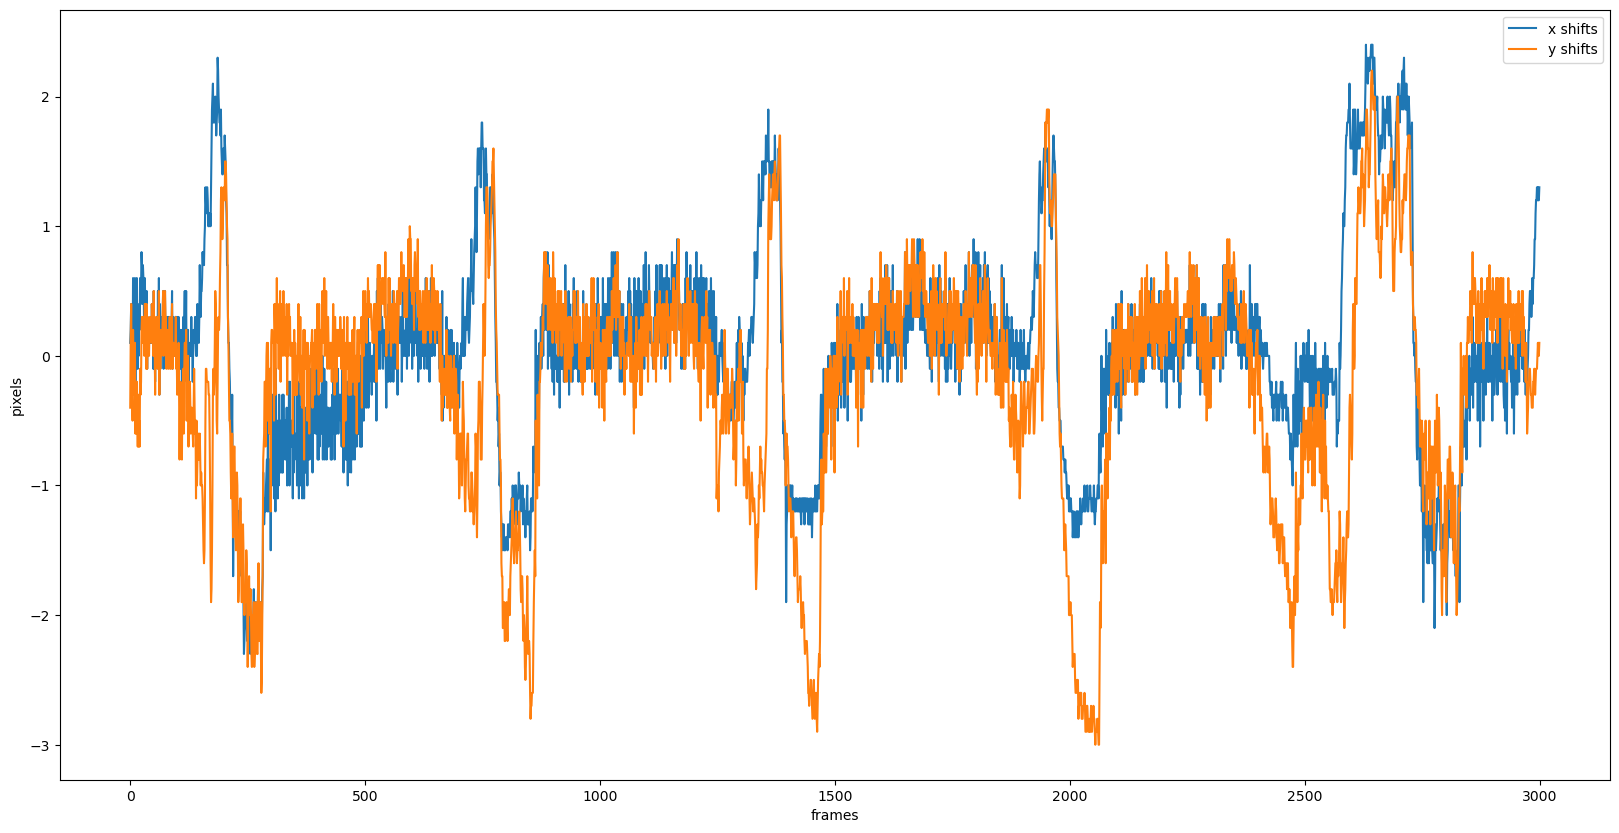

In [9]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels');

In [ ]:
%%capture
#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

      250201 [motion_correction.py:motion_correct_batch_pwrigid():2984] [32920] Adding to movie 296.0
      250202 [motion_correction.py:motion_correct_batch_pwrigid():2987] [32920] 0
      250203 [motion_correction.py:motion_correct_batch_pwrigid():2997] [32920] saving mmap of C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46.tif
      250211 [motion_correction.py:motion_correction_piecewise():3142] [32920] Number of Splits: 14
      250212 [motion_correction.py:motion_correction_piecewise():3176] [32920] Saving file as C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
      250214 [motion_correction.py:motion_correction_piecewise():3182] [32920] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  

In [ ]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=60, q_max=99.5, magnification=2, bord_px=bord_px_rig)

In [ ]:
#%% visualize elastic shifts
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [ ]:
cm.stop_server(dview=dview) # stop the server

In [ ]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');

In [17]:
# print crispness values
print('Crispness original: ' + str(int(crispness_orig)))
print('Crispness rigid: ' + str(int(crispness_rig)))
print('Crispness elastic: ' + str(int(crispness_els)))

Crispness original: 1937
Crispness rigid: 2758
Crispness elastic: 2848


KeysView(NpzFile 'C:\\Users\\HSH Lab\\caiman_data\\example_movies\\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000_metrics.npz


      278241 [movies.py:                load():1639] [43856] mmap


15.31141+/-7.773686 ; 2848.1125 ; 5.024257060099677
Loading data with base C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000


      278607 [colorbar.py:_get_ticker_locator_formatter():859] [43856] locator: <matplotlib.ticker.AutoLocator object at 0x0000021C1A039A80>
      278625 [movies.py:                load():1639] [43856] mmap


KeysView(NpzFile 'C:\\Users\\HSH Lab\\caiman_data\\example_movies\\Sue_2x_3000_40_-46_rig__d1_170_d2_170_d3_1_order_F_frames_3000_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_rig__d1_170_d2_170_d3_1_order_F_frames_3000_metrics.npz
23.156504+/-14.882817 ; 2758.9792 ; 5.104358212421173
Loading data with base C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_rig__d1_170_d2_170_d3_1_order_F_frames_3000


      278998 [colorbar.py:_get_ticker_locator_formatter():859] [43856] locator: <matplotlib.ticker.AutoLocator object at 0x0000021C19FE5B10>
      279014 [movies.py:                load():1655] [43856] File request:[C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46.mmap] not found!


KeysView(NpzFile 'C:\\Users\\HSH Lab\\caiman_data\\example_movies\\Sue_2x_3000_40_-46_metrics.npz' with keys: flows, norms, correlations, smoothness, tmpl...)
C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46_metrics.npz
143.7634+/-125.54292 ; 1937.2599 ; 5.794714936147785
Loading data with base C:\Users\HSH Lab\caiman_data\example_movies\Sue_2x_3000_40_-46


      279532 [colorbar.py:_get_ticker_locator_formatter():859] [43856] locator: <matplotlib.ticker.AutoLocator object at 0x0000021C19E52350>
      279555 [font_manager.py:    _findfont_cached():1411] [43856] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
      279556 [font_manager.py:    _findfont_cached():1423] [43856] findfont: score(FontEntry(fname='C:\\Users\\HSH Lab\\anaconda3\\envs\\caiman\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
      279557 [font_manager.py:    _findfont_cached():1423] [43856] findfont: score(FontEntry(fname='C:\\Users\\HSH Lab\\anaconda3\\envs\\caiman\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
      279557 [font_manager.py:    _findf

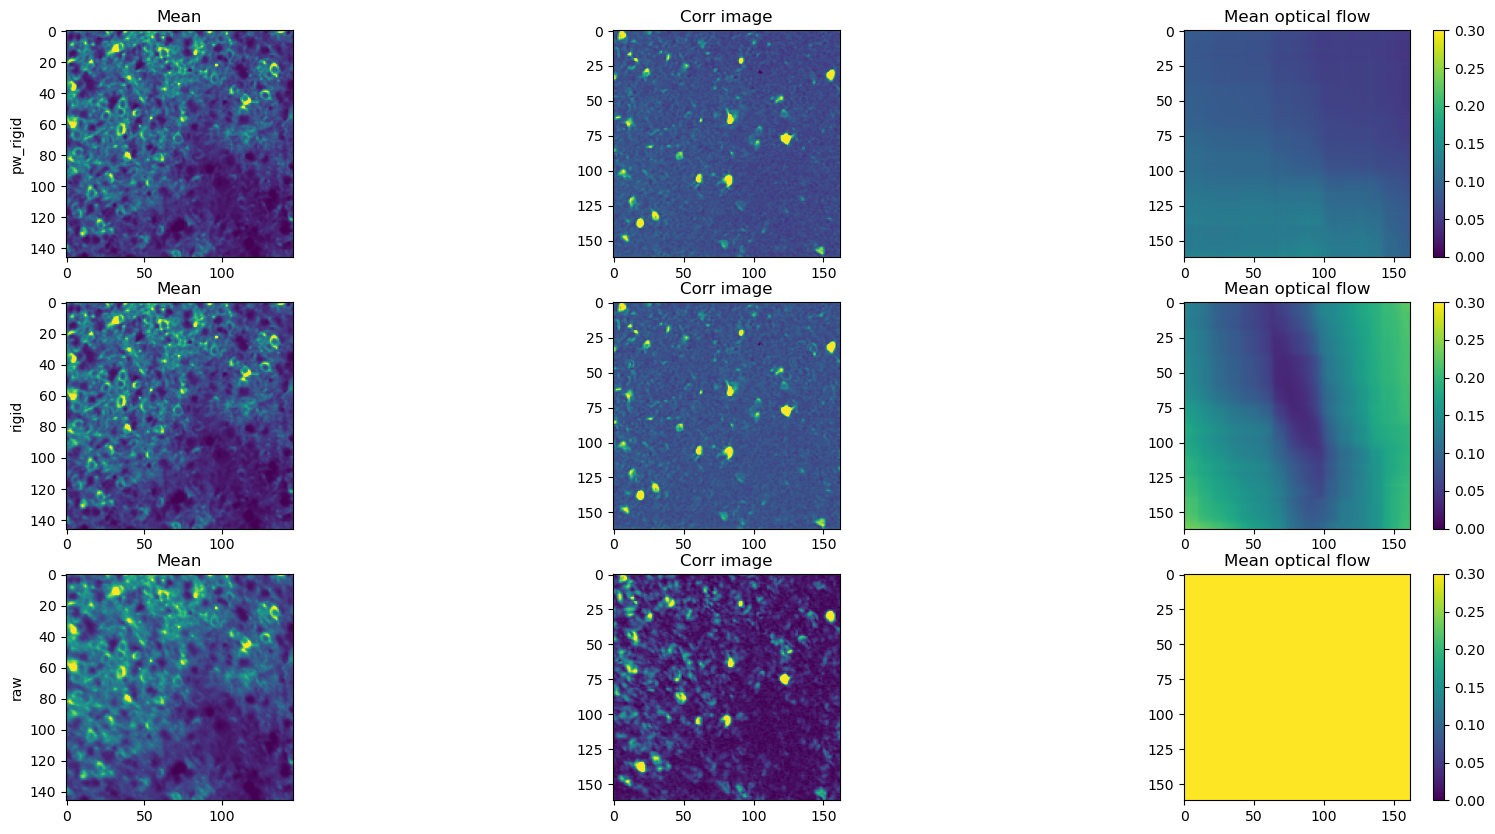

In [18]:
#%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(mc.fname_tot_els[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname_tot_rig[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname[0],         'metrics', swapsuffix='npz'),
      ]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        print(f"Loading data with base {fl[:-12]}")
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow');  